Filename (no extensions!) Run4_20


----------------------------------------------------------
Epoch:  1   GL = [-1.549e-03 -1.000e-04 -1.000e-04 -2.000e-04  0.000e+00 -2.000e-05
  0.000e+00 -2.000e-05 -2.000e-08  2.000e-08]  R-value = 1205.1006454765097
Epoch:  2   GL = [-1.349e-03  7.395e-05 -9.138e-05 -1.492e-04  0.000e+00 -1.412e-05
  0.000e+00 -1.412e-05  1.396e-08  1.529e-08]  R-value = 1193.399274038576
Epoch:  3   GL = [-7.814e-04  6.029e-05  2.696e-05 -1.202e-04  0.000e+00 -1.150e-05
  0.000e+00 -1.150e-05  1.136e-08  1.301e-08]  R-value = 955.9999548440219
Epoch:  4   GL = [-5.558e-04  5.204e-05  2.029e-05 -1.040e-04  0.000e+00 -9.924e-06
  0.000e+00 -9.924e-06  9.817e-09  1.123e-08]  R-value = 980.9092820483933
Epoch:  5   GL = [-1.350e-03  7.039e-05  5.477e-05  8.295e-05  0.000e+00 -8.837e-06
  0.000e+00 -8.837e-06  1.166e-08  1.436e-08]  R-value = 925.0604351994458
Epoch:  6   GL = [-9.676e-04  6.405e-05  4.977e-05  7.540e-05  0.000e+00 -8.024e-06
  0.000e+00 -8.024e-06  1.058e-08  1.305e-08]  R-value = 1459

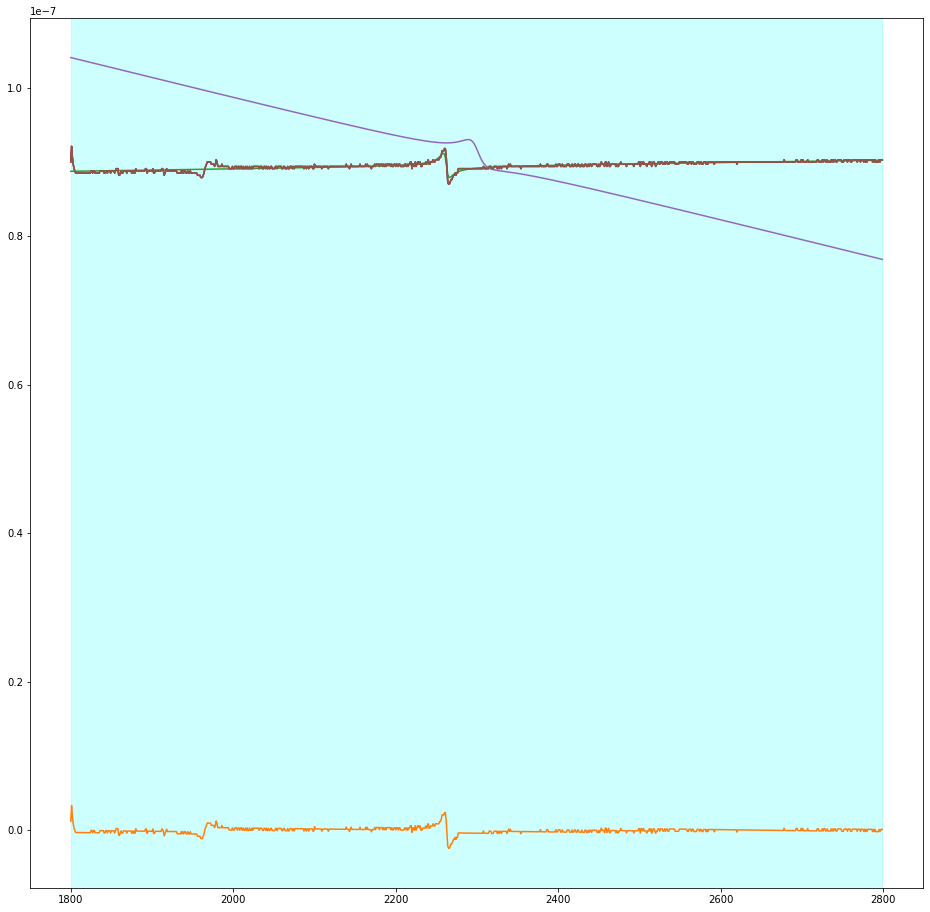

In [304]:
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy.optimize as opt
import scipy.ndimage as ndi
import statistics as stat
import sys
import tkinter as tk
from tkinter import filedialog
import time
#----------------------------------------------------------
t0 = time.time()
pi = 3.14159265358979323846
wStart = 0 #automatically set
wEnd = 12000
peak_min_width = 30 #required peak width to count as an absorptive peak
STD = 0.78    #required sigma to count as an absorptive peak
PTP = 2        #required peak-to-peak distance (in sigma) to count as an elastic peak
WTH = 1200 #width multiplier for CI (confidence interval) to completely include peak
σS = 30    #smoothing for initial peak finding def:30
θErr =1.5    #angle offset (max absolute value in radians)
AMax = 1000       #max |amplitude| 

#ADAM optimization algorithm  (https://arxiv.org/pdf/1412.6980.pdf)
lr = np.array([0.002,0.001,0.001,0.002,0.0002,0.0002,0.0002,0.0002,0.0000002,0.0000002])
B1 = np.array([0.5,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9])
B2 = np.array([0.7,0.999,0.999,0.999,0.999,0.999,0.999,0.999,0.999,0.999])
m = np.array([0]*len(lr))
v = np.array([0]*len(lr))
epson = 0.000000000001
epsil = np.array([epson]*len(lr))
epochs = 1000
#----------------------------------------------------------
#np.set_printoptions(precision=3)
#root = tk.Tk()
#root.withdraw()

#file_path = filedialog.askopenfilename()
#file = open(file_path)
def fileOpen():
    try:
        file = open(input("Filename (no extensions!)")+'.txt')
        print("----------------------------------------------------------")
        return file
    except:
        print("ERROR: Incorrect Filename")
        file = fileOpen()
    if 'file' in locals():
        return file
    else:
        fileOpen()
file = fileOpen()
#----------------------------------------------------------
#DATA STRIP
def dataStrip():
    n = 0
    wStrt,wEn=0,0
    lines = []
    for x in file:  
        ### Ignore first two lines ##
        if n==0:
            ws = x.strip().split("kHz")
            wStrt =int(1000*float(ws[0]))
            wEn =int(1000*float(ws[1][(15):-1]))
            n +=1
        elif n==1:
            n +=1
        else:
            ### Remove '\n' from elements ###
            t = x.strip()
            temp = t.split('\t')
            lines.append(temp)
    #----------------------------------------------------------
    #DATA ARRAY
    wL,rL,xL,yL = [],[],[],[]
    for line in lines:
        wL.append(float(line[0]))
        rL.append(float(line[1]))
        xL.append(float(line[2]))
        yL.append(float(line[3]))
    f,r,x,y=np.array(wL),np.array(rL),np.array(xL),np.array(yL)
    return f,r,x,y,wStrt,wEn
#----------------------------------------------------------
f,r,x,y,wStart,wEnd = dataStrip() #//for some reason this doesn't work in output (wStart and end need to be global?)
r2 = pow(r,2)
#----------------------------------------------------------
def bkg(f_in,m,b):
    return (f_in*m + b)
def quad(f_in,m1,b1,m2,b2):
    return pow(bkg(f_in,m1,b1),2)+pow(bkg(f_in,m2,b2),2)
def quadZ(f_in,m1,b1,m2,b2,z0,z1):
    return pow(bkg(f_in,m1,b1),2)+pow(bkg(f_in,m2,b2),2)+bkg(f_in,z1,z0)
def firstShift(w,x):
    x_bkg_p, x_bkg_COV = opt.curve_fit(bkg, w, x)
    x_bkg = bkg(w,x_bkg_p[0],x_bkg_p[1])
    x_shift = x.copy()-x_bkg
    return x_shift, x_bkg_p
def quadFit(f_in,r2_in):
    r2_bkg_p, r2_bkg_COV = opt.curve_fit(quad, f_in, r2_in)
    r2_bkg = quad(f_in,r2_bkg_p[0],r2_bkg_p[1],r2_bkg_p[2],r2_bkg_p[3])
    r2_shift = r2.copy()-r2_bkg
    return r2_shift, r2_bkg_p
def peaks(w,_x):
    σ = stat.stdev(_x)
    TRHLD = STD*σ
    _clean = [0]*len(w)
    for f in range(0,len(w)):
        if((_x[f]<TRHLD) and (_x[f]>-TRHLD)):
            _clean[f]=_x[f]
    _peak_data = []#[[init, final w],[//,//]..]
    st = 0;
    collect = False
    for f in range(0,len(w)-1):
        if(_clean[f]==0 and _clean[f+1]!=0):
            _peak_data.append([st,f])
            collect = True
        if(_clean[f]!=0 and _clean[f+1]==0):
            st = f
    j=0
    for i in range(0,len(_peak_data)):
        length = (_peak_data[j][1] - _peak_data[j][0])
        if(length<=20):
            _peak_data.pop(j)
            j-=1
        j+=1
    r = _x - _clean
    return _clean,r,_peak_data
def secondShift(w,x):
    _x1,x_p = firstShift(w,x)
    return (peaks(w,_x1),x_p)
#------------------
def ela(w_in, λ, w0, A, sgn):#elastic
    return sgn*A*(pow(w0,2) - pow(w_in,2))/(pow((pow(w0,2) - pow(w_in,2)),2) + pow(λ*w_in,2))
def arp(w_in, λ, w0, A, sgn):#absorptive
    return sgn*A*λ*w_in/(pow((pow(w0,2) - pow(w_in,2)),2) + pow(λ*w_in,2)) 
def R(w_in, λ, w0, A):
    return np.sqrt(pow(ela(w_in, λ, w0, A,1),2)+pow(arp(w_in, λ, w0, A, 1),2))
def R2(f_in, λ, w0, A,θ,m1,b1,m2,b2,z0,z1):
    w_in = 2*pi*f_in
    E = ela(w_in, λ, w0, A,1)
    B = arp(w_in, λ, w0, A, 1)
    k1 = (bkg(f_in,m1,b1)*math.sin(θ)+bkg(f_in,m2,b2)*math.cos(θ))
    k2 = (bkg(f_in,m1,b1)*math.cos(θ)-bkg(f_in,m2,b2)*math.sin(θ))
    return (pow(B,2)+pow(E,2)+ k1*B + k2*E +quadZ(f_in,m1,b1,m2,b2,z0,z1))

def posFit(f_in, λ, w0, A, m, b):
    w_in = 2*pi*f_in
    return R(w_in, λ, w0, A)+bkg(f_in,m,b)
def negFit(f_in, λ, w0, A, m, b):
    w_in = 2*pi*f_in
    return -R(w_in, λ, w0, A)+bkg(f_in,m,b)
def peakFilt(peaks,f):
    _peaks = []
    for peak in peaks:
        d = peak[1]-peak[0]
        sig = (WTH-1)/2
        st = int(peak[0]-WTH)#st = int(peak[0]-sig*d)
        if(st<0):
            st = 0
        ed = int(peak[1]+WTH)#ed = int(peak[1]+sig*d)
        if(ed>=len(f)):
            ed = len(f)-1
        _peaks.append([st,ed])
    return _peaks
def Rsquare(obs,exp):
    sig = stat.stdev(exp)**2
    return (np.sum((obs-exp)**2)/sig)
#------------------
plt.figure(figsize=(16,16))
r2_shift,r2_bkg_p = quadFit(f,r2)
peaks,x_bkg_p = secondShift(f,r)
clean,r0,peaks = peaks
eps= 0.0000001
epsM= 0.0000000001
#plt.plot(f,r0)
plt.plot(f,r2)
plt.plot(f,r2_shift)
#plt.plot(w,clean)
#print("PEAKS: ",f[_peaks[:]])
_peaks = peakFilt(peaks,f)
for i in range(0,len(_peaks)):
    x = int((_peaks[i][0]+_peaks[i][1])/2.0)
    Fguess = f[x]
    bounds=([1,f[_peaks[i][0]]*2*pi,0,x_bkg_p[0]-epsM,x_bkg_p[1]-eps], [200,f[_peaks[i][1]]*2*pi,400,x_bkg_p[0]+epsM,x_bkg_p[1]+eps])
    bounds2=([0,f[_peaks[i][0]]*2*pi,0,-10000*epsM,-100000*eps], [2000,f[_peaks[i][1]]*2*pi,400,10000*epsM,100000*eps])
    idx = f[_peaks[i][0]:_peaks[i][1]]
    #-------------------------------------
    p0 = [50,Fguess*2*pi,200,x_bkg_p[0],x_bkg_p[1]]
    #-------------------------------------
    #test value
    vA = r0[x]
    sgn = 1
    if(vA>=0):
        fit_p, fit_COV = opt.curve_fit(posFit,idx,r[_peaks[i][0]:_peaks[i][1]],p0=p0,bounds=bounds,maxfev=10000000)
    #    fit_p, fit_COV = opt.curve_fit(posFit,idx,r[_peaks[i][0]:_peaks[i][1]],p0=fit_p,bounds=bounds2,maxfev=10000000)
    #    plt.plot(f , posFit(f, fit_p[0], fit_p[1], fit_p[2], fit_p[3], fit_p[4]))
    else:
        fit_p, fit_COV = opt.curve_fit(negFit,idx,r[_peaks[i][0]:_peaks[i][1]],p0=p0,bounds=bounds,maxfev=10000000)
    #    fit_p, fit_COV = opt.curve_fit(negFit,idx,r[_peaks[i][0]:_peaks[i][1]],p0=fit_p,bounds=bounds2,maxfev=10000000)
    #    plt.plot(f , negFit(f, fit_p[0], fit_p[1], fit_p[2], fit_p[3], fit_p[4]))
        sgn = -1
    #----------------------------------------
    bounds22=([0,f[_peaks[i][0]]*2*pi,0,-pi,r2_bkg_p[0]-epsM,r2_bkg_p[1]-eps,r2_bkg_p[2]-epsM,r2_bkg_p[3]-eps,-1,-1], [2000,f[_peaks[i][1]]*2*pi,400,pi,r2_bkg_p[0]+epsM,r2_bkg_p[1]+eps,r2_bkg_p[2]+epsM,r2_bkg_p[3]+eps,1,1])
    
    p02 = [fit_p[0], fit_p[1], fit_p[2],0,r2_bkg_p[0],r2_bkg_p[1],r2_bkg_p[2],r2_bkg_p[3],0,0]
    def fits(p03):   
        fit_p, fit_COV = opt.curve_fit(R2,idx,r2[_peaks[i][0]:_peaks[i][1]],p0=p03,bounds=bounds22,maxfev=10000000)
        deltaB = [20,200,100,100,epsM,eps,epsM,eps,eps,epsM]
        bounds23=(fit_p-deltaB,fit_p+deltaB)
        fit_p, fit_COV = opt.curve_fit(R2,idx,r2[_peaks[i][0]:_peaks[i][1]],p0=fit_p,bounds=bounds23,maxfev=10000000)
        Rsquared = Rsquare(r2[_peaks[i][0]:_peaks[i][1]],R2(idx, fit_p[0], fit_p[1], fit_p[2], fit_p[3], fit_p[4],fit_p[5],fit_p[6],fit_p[7],fit_p[8],fit_p[9]))
        return fit_p,fit_COV,Rsquared
    def bounding(p03,bounds03):
        Up = bounds03[1]
        Down = bounds03[0]
        ups = np.subtract(p03,Up)
        dps = np.subtract(Down, p03)
        for i in range(0,len(p03)):
            if(ups[i]>=0):
                p03[i] = Up[i]-epsM
            if(dps[i]>=0):
                p03[i] = Down[i]+epsM
        return p03
    #theta optimization (epsilon - epsM)
    gradL = lr.copy()
    gradZ = lr.copy()
    for j in range(1,epochs):
        for h in range(0, len(p02)):
            fit_p,fit_COV,Rs = fits(p02)
            p02[h] = p02[h] + epson
            #Limiting bounds
            p02 = bounding(p02,bounds22)
            fit_p,fit_COV,RsE = fits(p02)
            grad = (RsE-Rs)/epson
            gradZ[h]=grad
            p02[h] = p02[h] - epson
        #ADAM implementation
        m = B1*m + (1-B1)*gradZ
        v = B1*v + (1-B1)*(gradZ**2)
        mhat = m/(1-(B1**j))
        vhat = v/(1-(B2**j))
        gradL = (lr*mhat)/(np.sqrt(vhat)+epsil)
        #gradL = gradZ*lr
        p02 = np.subtract(p02,gradL)
        #Limiting bounds
        p02 = bounding(p02,bounds22)
        #--------------------------
        print("Epoch: ", j,"  GL =",gradL," R-value =",Rs)
        #print("Epoch: ", j,"  G =",gradZ)
        #print("  P =",p02)
    print("DONE.")
    fit_p, fit_COV = opt.curve_fit(R2,idx,r2[_peaks[i][0]:_peaks[i][1]],p0=p02,bounds=bounds22,maxfev=10000000)
    
    #bounds24=([0,f[_peaks[i][0]]*2*pi,0,-pi,-1,-1,-1,-1], [2000,f[_peaks[i][1]]*2*pi,400,pi,1,1,1,1])
   
    plt.plot(f , R2(f, fit_p[0], fit_p[1], fit_p[2], fit_p[3], fit_p[4],fit_p[5],fit_p[6],fit_p[7],fit_p[8],fit_p[9]))
    #-------------------------------------
    print("---------------")
    print("R Amplitude:\t\t", fit_p[2],"\nResonance Frequency:\t" , fit_p[1]/(2*pi), "Hz\nQuality:\t\t" , fit_p[1]/(fit_p[0]),"\nGamma:\t\t\t" , (fit_p[0]))
    #print("\n-\ LinearFit: y =",fit_p[3],"x +",fit_p[4])
    print("\n-\ QuadFit: ",fit_p[3],fit_p[4],fit_p[5],fit_p[6],fit_p[7],fit_p[8],fit_p[9])
    print("R-value: ",Rs)
    print("Time: ",(time.time()-t0))
    #plt.plot(idx,r[_peaks[i][0]:_peaks[i][1]])
    plt.plot(idx,r2[_peaks[i][0]:_peaks[i][1]])
    plt.axvspan(f[_peaks[i][0]], f[_peaks[i][1]], color='cyan', alpha=0.1)

---------------
R Amplitude:		 176.14785718992113 
Resonance Frequency:	 2134.660261708729 Hz
Quality:		 239.36932669707224 
Gamma:			 56.032517521186925

-\ QuadFit:  0.5012903567260951 -5.438129126475898e-08 0.0001667939737667447 -3.048263636506375e-08 9.355500397344044e-05 -1.837409108465867e-08 7.100319051802745e-12
R-value:  0.0043238455509709665


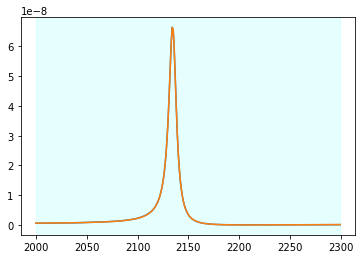

In [302]:
print("---------------")
print("R Amplitude:\t\t", fit_p[2],"\nResonance Frequency:\t" , fit_p[1]/(2*pi), "Hz\nQuality:\t\t" , fit_p[1]/(fit_p[0]),"\nGamma:\t\t\t",(fit_p[0]))
#print("\n-\ LinearFit: y =",fit_p[3],"x +",fit_p[4])
print("\n-\ QuadFit: ",fit_p[3],fit_p[4],fit_p[5],fit_p[6],fit_p[7],fit_p[8],fit_p[9])
print("R-value: ",Rs)
#plt.plot(idx,r[_peaks[i][0]:_peaks[i][1]])
plt.plot(f,r2)
plt.plot(f,R2(f, fit_p[0], fit_p[1], fit_p[2], fit_p[3], fit_p[4],fit_p[5],fit_p[6],fit_p[7],fit_p[8],fit_p[9]))
plt.axvspan(f[_peaks[i][0]], f[_peaks[i][1]], color='cyan', alpha=0.1)


---------------
R Amplitude:		 153.0882016331842 
Resonance Frequency:	 2134.55281547265 Hz
Quality:		 287.1938630584009 
Gamma:			 46.699434120043456

-\ QuadFit:  0.6247248050082144 -5.440750426247777e-08 0.00016661612264547997 -3.05152149994776e-08 9.355497528619606e-05
R-value:  27.517028690880768


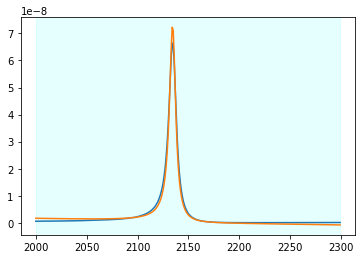

In [242]:
    print("---------------")
    print("R Amplitude:\t\t", fit_p[2],"\nResonance Frequency:\t" , fit_p[1]/(2*pi), "Hz\nQuality:\t\t" , fit_p[1]/(fit_p[0]),"\nGamma:\t\t\t" , (fit_p[0]))
    #print("\n-\ LinearFit: y =",fit_p[3],"x +",fit_p[4])
    print("\n-\ QuadFit: ",fit_p[3],fit_p[4],fit_p[5],fit_p[6],fit_p[7])
    print("R-value: ",Rs)
    #plt.plot(idx,r[_peaks[i][0]:_peaks[i][1]])
    plt.plot(f,r2)
    plt.plot(f,R2(f, fit_p[0], fit_p[1], fit_p[2], fit_p[3], fit_p[4],fit_p[5],fit_p[6],fit_p[7])-0.3e-8)
    plt.axvspan(f[_peaks[i][0]], f[_peaks[i][1]], color='cyan', alpha=0.1)

---------------
R Amplitude:		 153.0882016331842 
Resonance Frequency:	 2134.55281547265 Hz
Quality:		 287.1938630584009 
Gamma:			 46.699434120043456

-\ QuadFit:  0.6247248050082144 -5.440750426247777e-08 0.00016661612264547997 -3.05152149994776e-08 9.355497528619606e-05
R-value:  27.517028690880768


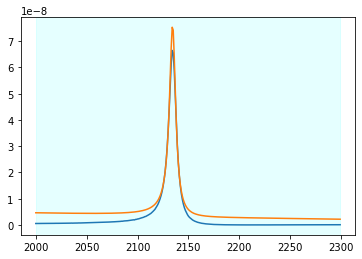

In [244]:
    print("---------------")
    print("R Amplitude:\t\t", fit_p[2],"\nResonance Frequency:\t" , fit_p[1]/(2*pi), "Hz\nQuality:\t\t" , fit_p[1]/(fit_p[0]),"\nGamma:\t\t\t" , (fit_p[0]))
    #print("\n-\ LinearFit: y =",fit_p[3],"x +",fit_p[4])
    print("\n-\ QuadFit: ",fit_p[3],fit_p[4],fit_p[5],fit_p[6],fit_p[7])
    print("R-value: ",Rs)
    #plt.plot(idx,r[_peaks[i][0]:_peaks[i][1]])
    plt.plot(f,r2)
    plt.plot(f,R2(f, fit_p[0], fit_p[1], fit_p[2], fit_p[3], fit_p[4],fit_p[5],fit_p[6],fit_p[7]))
    plt.axvspan(f[_peaks[i][0]], f[_peaks[i][1]], color='cyan', alpha=0.1)

In [33]:
%matplotlib  inline